In [1]:
!pip install -q kaggle torch torchvision pycocotools pillow matplotlib tqdm


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sowmyavanjarapu","key":"79ff620a8c8fa314de18d50cc3f906f1"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Create a folder to store COCO data
!mkdir -p /content/coco2017
%cd /content/coco2017

/content/coco2017


In [4]:
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-11-16 04:23:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.8.139, 3.5.3.105, 52.217.126.9, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.8.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  50.2MB/s    in 9m 2s   

2025-11-16 04:32:04 (34.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-11-16 04:32:05--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.109.177, 52.217.42.188, 54.231.193.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.109.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.

In [5]:
!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

In [6]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on device:', DEVICE)

Running on device: cuda


In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import albumentations as A
import torchvision.models as models

# Transform: resize images/masks to 128x128 for simplicity
transform = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])


In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)  # grayscale mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        image = TF.to_tensor(image)
        mask = torch.from_numpy(mask).unsqueeze(0).float() / 255.0
        return image, mask


In [15]:
from pycocotools.coco import COCO
import cv2
import numpy as np
import os
from tqdm import tqdm

annFile = "/content/coco2017/annotations/instances_train2017.json"
coco = COCO(annFile)

output_dir = "/content/coco2017/train_masks"
os.makedirs(output_dir, exist_ok=True)

for img_id in tqdm(coco.getImgIds(), desc="Generating masks"):
    img_info = coco.loadImgs(img_id)[0]
    h, w = img_info["height"], img_info["width"]

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((h, w), dtype=np.uint8)

    for ann in anns:
        m = coco.annToMask(ann)
        mask = np.maximum(mask, m * 255)

    out_name = img_info["file_name"].replace(".jpg", ".png")
    cv2.imwrite(f"{output_dir}/{out_name}", mask)


loading annotations into memory...
Done (t=12.76s)
creating index...
index created!


Generating masks: 100%|██████████| 118287/118287 [11:07<00:00, 177.29it/s]


In [16]:
train_images_dir = "/content/coco2017/train2017"
train_masks_dir = "/content/coco2017/train_masks"

train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)


In [17]:
class UNet(nn.Module):
    def __init__(self, pretrained=True):
        super(UNet, self).__init__()
        backbone = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
        self.base_layers = list(backbone.children())

        self.enc1 = nn.Sequential(*self.base_layers[:3])
        self.enc2 = nn.Sequential(*self.base_layers[3:5])
        self.enc3 = self.base_layers[5]
        self.enc4 = self.base_layers[6]
        self.enc5 = self.base_layers[7]

        self.center = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True)
        )

        self.dec5 = self.decoder_block(512 + 512, 512)
        self.dec4 = self.decoder_block(512 + 256, 256)
        self.dec3 = self.decoder_block(256 + 128, 128)
        self.dec2 = self.decoder_block(128 + 64, 64)
        self.dec1 = nn.Sequential(
    nn.Conv2d(64 + 64, 1, 1),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
)


    def decoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        c = self.center(e5)

        d5 = self.dec5(torch.cat([c, e5], 1))
        d4 = self.dec4(torch.cat([d5, e4], 1))
        d3 = self.dec3(torch.cat([d4, e3], 1))
        d2 = self.dec2(torch.cat([d3, e2], 1))
        out = self.dec1(torch.cat([d2, e1], 1))
        return torch.sigmoid(out)

# Initialize model, loss, optimizer
model = UNet().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 196MB/s]


In [18]:
EPOCHS = 4  # small for initial testing

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Avg Loss: {total_loss/len(train_loader):.4f}")

100%|██████████| 29572/29572 [22:45<00:00, 21.65it/s]


Epoch [1/4] | Avg Loss: 0.3642


100%|██████████| 29572/29572 [22:49<00:00, 21.59it/s]


Epoch [2/4] | Avg Loss: 0.3337


100%|██████████| 29572/29572 [23:01<00:00, 21.40it/s]


Epoch [3/4] | Avg Loss: 0.3206


100%|██████████| 29572/29572 [23:08<00:00, 21.31it/s]

Epoch [4/4] | Avg Loss: 0.3125


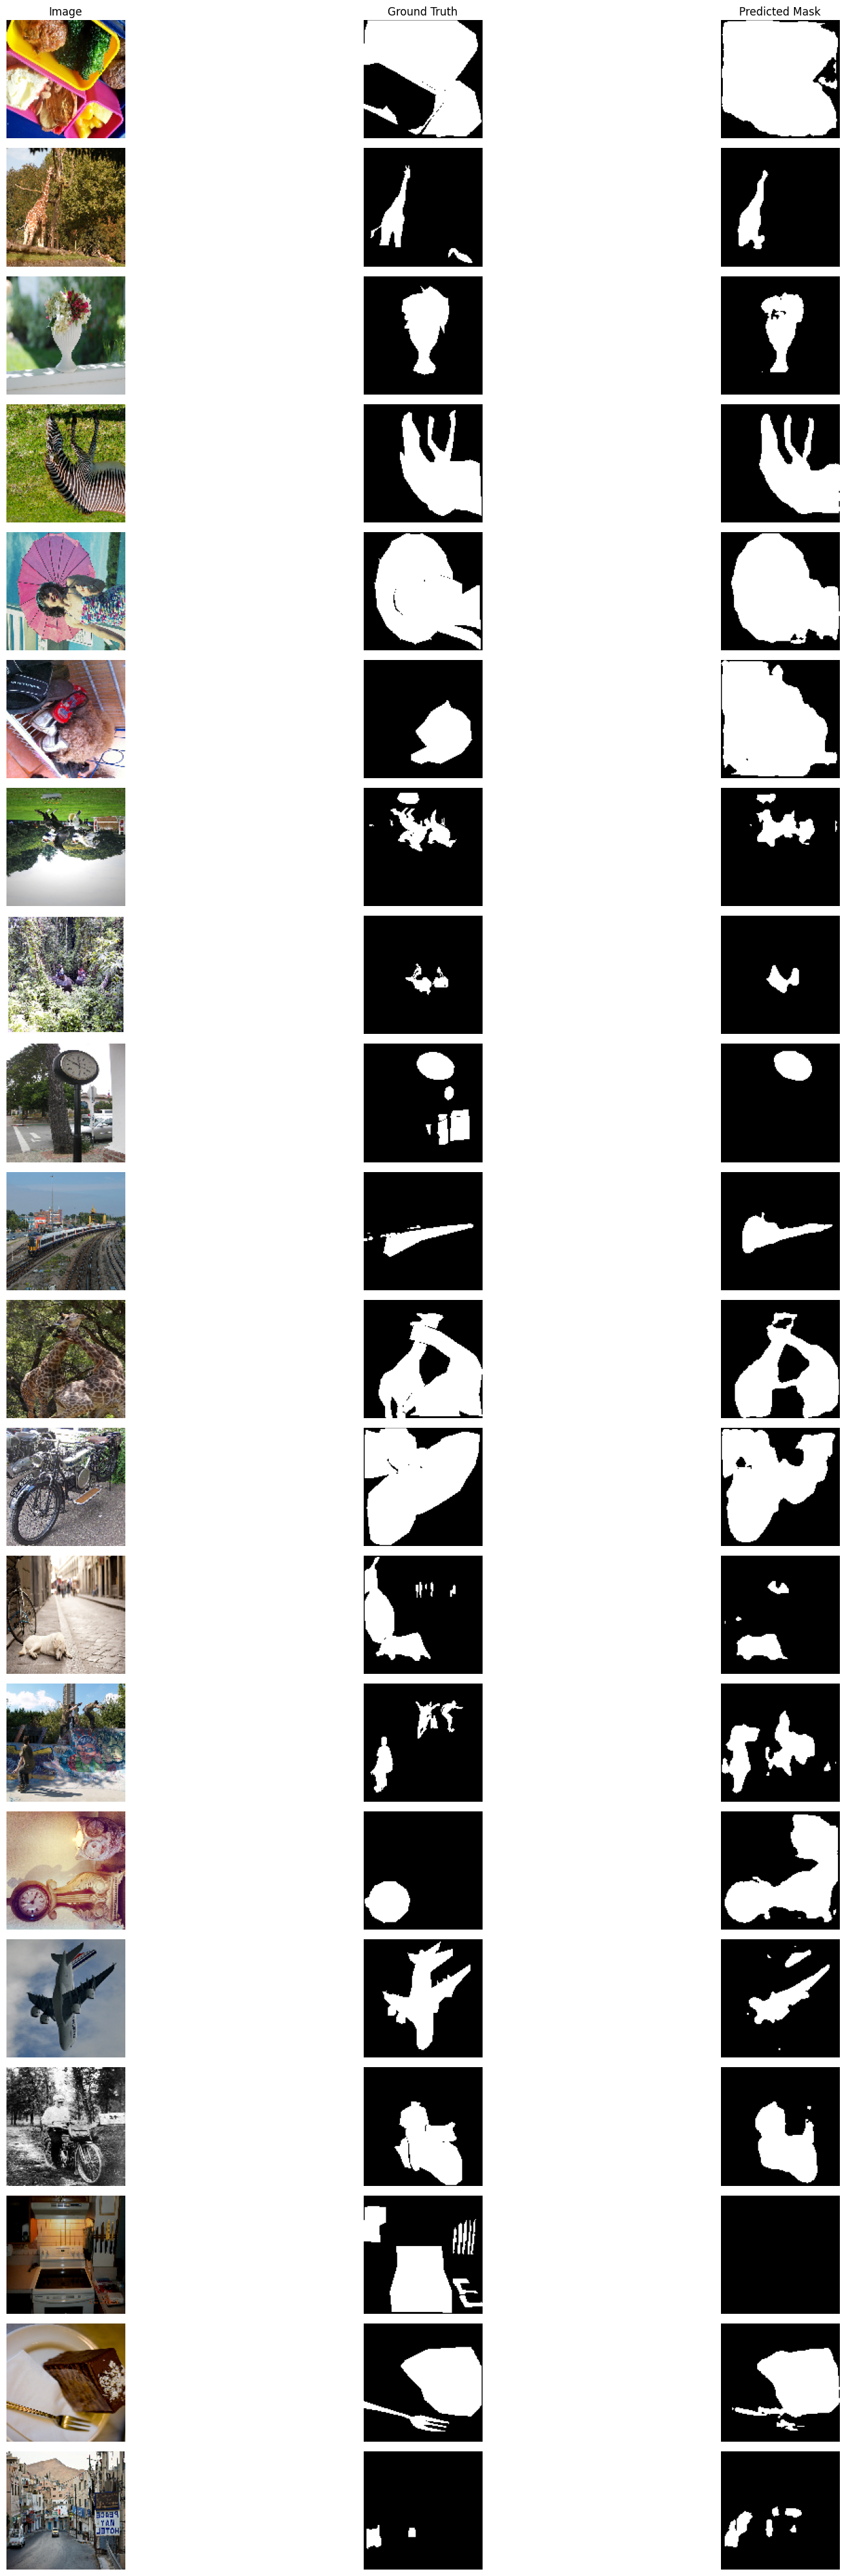

In [19]:
model.eval()  # evaluation mode
num_images = 20  # number of images to display

plt.figure(figsize=(20, num_images * 2))  # adjust figure size

with torch.no_grad():
    for i in range(num_images):
        img, mask = train_dataset[i]
        pred_mask = model(img.unsqueeze(0).to(DEVICE))
        pred_mask = (pred_mask.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

        # display image
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(img.permute(1,2,0))
        if i == 0: plt.title("Image")
        plt.axis('off')

        # display ground truth mask
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        if i == 0: plt.title("Ground Truth")
        plt.axis('off')

        # display predicted mask
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        if i == 0: plt.title("Predicted Mask")
        plt.axis('off')

plt.tight_layout()
plt.show()
